**MUST BE RUN ON GOOGLE COLAB ONLY**

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.8 MB/s eta 0:00:00


In [ ]:
import re
import hashlib
from google.colab import files
import os
from Bio import SeqIO

# Define a function to generate a unique job name by combining a base name with a hash of the sequence
def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]

# Upload a file using Google Colab's file upload feature
uploaded = files.upload()
fasta_filename = list(uploaded.keys())[0]

# Read the first record from the uploaded FASTA file and extract the sequence
with open(fasta_filename, "r") as fasta_file:
    record = next(SeqIO.parse(fasta_file, "fasta"))
    query_sequence = str(record.seq)

# Set a base job name and sanitize it to create a valid folder name
jobname = 'ProteinStruct Prediction'
query_sequence = "".join(query_sequence.split())  # Remove any whitespaces in the sequence
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)  # Remove non-alphanumeric characters

# Generate a unique job name using the base name and a hash of the query sequence
jobname = add_hash(basejobname, query_sequence)

# Create a directory named after the job for storing result files
os.makedirs(jobname, exist_ok=True)

# Write the query information to a CSV file within the job directory
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

# Template mode configuration: select "none", "pdb100", or "custom" for template handling
template_mode = "none"  # Set to "none", "pdb100", or "custom"
if template_mode == "pdb100":
    use_templates = True
    custom_template_path = None
elif template_mode == "custom":
    # If using custom templates, create a template folder and upload template files
    custom_template_path = os.path.join(jobname, f"template")
    os.makedirs(custom_template_path, exist_ok=True)
    uploaded_templates = files.upload()
    use_templates = True
else:
    custom_template_path = None
    use_templates = False

Saving uniparc_active_p1.fasta to uniparc_active_p1.fasta


In [ ]:
import os

# Configuration options for installing additional software and tools
USE_AMBER = True          # Set to True if Amber is needed for molecular dynamics
USE_TEMPLATES = True      # Set to True if template-based modeling is needed
PYTHON_VERSION = "3.8"    # Python version to use with ColabFold dependencies

# Install ColabFold if not already installed
if not os.path.isfile("COLABFOLD_READY"):
    print("Installing ColabFold...")
    os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")

    # Reconfigure JAX for TPU compatibility (optional: only needed if using TPU)
    if os.environ.get('TPU_NAME', False):
        os.system("pip uninstall -y jax jaxlib")
        os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")

    # Create symlinks to ColabFold and AlphaFold modules for easier access
    os.system("ln -s /usr/local/lib/python3*/dist-packages/colabfold colabfold")
    os.system("ln -s /usr/local/lib/python3*/dist-packages/alphafold alphafold")
    os.system("touch COLABFOLD_READY")  # Mark ColabFold as installed

# Install Miniforge (Conda) if not already installed
if not os.path.isfile("CONDA_READY"):
    print("Installing Conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")  # Run installation in silent mode
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")  # Mark Conda as installed

# Install HHsuite if template-based modeling is enabled
if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("Installing HHsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")  # Mark HHsuite as installed

# Install Amber if molecular dynamics are enabled
if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("Installing Amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")  # Mark Amber as installed

Installing ColabFold...
Installing Conda...
Installing HHsuite...
Installing Amber...


In [ ]:
# Define settings for multiple sequence alignment (MSA) mode and pairing mode
msa_mode = "mmseqs2_uniref_env"    # Options include mmseqs2 for database search or single sequence mode
pair_mode = "unpaired_paired"      # Set pairing mode (unpaired/pairing for MSA sequences)

# Configure MSA file path and create MSA file based on the selected mode
if "mmseqs2" in msa_mode:
    # Use MMseqs2 MSA mode, creating a path for the a3m file
    a3m_file = os.path.join(jobname, f"{jobname}.a3m")

else:  # Single Sequence Mode
    # If using a single sequence mode, generate a single sequence a3m file
    a3m_file = os.path.join(jobname, f"{jobname}.single_sequence.a3m")
    with open(a3m_file, "w") as text_file:
        text_file.write(">1\n%s" % query_sequence)  # Write query sequence in FASTA format

In [ ]:
# Model and processing parameters for structure prediction
model_type = "auto"                # Specify the model type (e.g., auto, alphafold2_multimer_v3)
num_recycles = 3                   # Number of recycles for model refinement
recycle_early_stop_tolerance = 0.0 # Tolerance level to stop early in recycling
relax_max_iterations = 200         # Max iterations allowed during model relaxation
pairing_strategy = "greedy"        # Strategy for pairing sequences in multimeric structures
max_msa = None                     # Limit on MSA depth; None means no limit
num_seeds = 1                      # Number of random seeds for stochastic sampling
use_dropout = False                # Toggle dropout usage in prediction
save_all = False                   # Option to save all intermediate outputs
save_recycles = False              # Option to save recycles separately
save_to_google_drive = False       # Option to save results to Google Drive
dpi = 200                          # Set DPI for saved images

# Modify parameters if using the specific multimer v3 model
if model_type == "alphafold2_multimer_v3":
    num_recycles = 20
    recycle_early_stop_tolerance = 0.5  # Higher tolerance for early stopping in multimer mode

# Authenticate with Google Drive if saving results to Drive
if save_to_google_drive:
    from pydrive2.drive import GoogleDrive
    from pydrive2.auth import GoogleAuth
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    print("Authenticated with Google Drive.")

# Print final configuration settings for verification
print(f"Model Type: {model_type}")
print(f"Number of Recycles: {num_recycles}")
print(f"Recycle Early Stop Tolerance: {recycle_early_stop_tolerance}")
print(f"Relax Max Iterations: {relax_max_iterations}")
print(f"Pairing Strategy: {pairing_strategy}")
print(f"Max MSA: {max_msa}")
print(f"Number of Seeds: {num_seeds}")
print(f"Use Dropout: {use_dropout}")
print(f"Save All: {save_all}")
print(f"Save Recycles: {save_recycles}")
print(f"Save to Google Drive: {save_to_google_drive}")
print(f"Image DPI: {dpi}")

Model Type: auto
Number of Recycles: 3
Recycle Early Stop Tolerance: 0.0
Relax Max Iterations: 200
Pairing Strategy: greedy
Max MSA: None
Number of Seeds: 1
Use Dropout: False
Save All: False
Save Recycles: False
Save to Google Drive: False
Image DPI: 200


2024-11-12 13:59:47,697 Running on GPU
2024-11-12 13:59:48,101 Found 8 citations for tools or databases
2024-11-12 13:59:48,103 Query 1/1: ProteinStructPrediction_5993e (length 61)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:03 remaining: 00:00]


2024-11-12 13:59:51,244 Sequence 0 found no templates


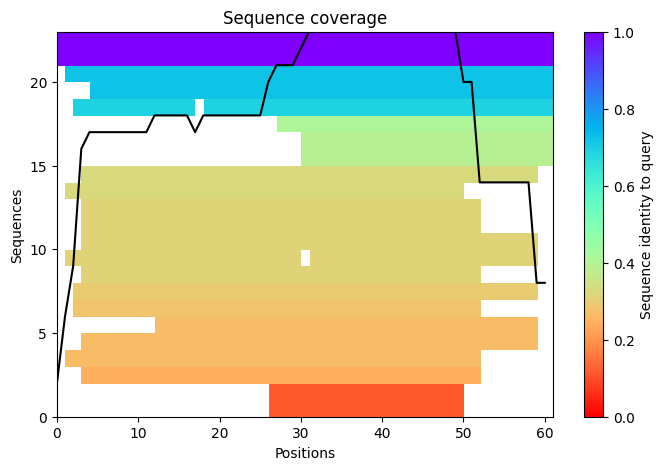

2024-11-12 13:59:52,270 Setting max_seq=27, max_extra_seq=1
2024-11-12 14:00:31,614 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=71.4 pTM=0.272
2024-11-12 14:00:32,196 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=73.1 pTM=0.294 tol=6
2024-11-12 14:00:32,778 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=73.3 pTM=0.292 tol=1.11
2024-11-12 14:00:33,360 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=73.1 pTM=0.292 tol=0.604
2024-11-12 14:00:33,361 alphafold2_ptm_model_1_seed_000 took 27.7s (3 recycles)


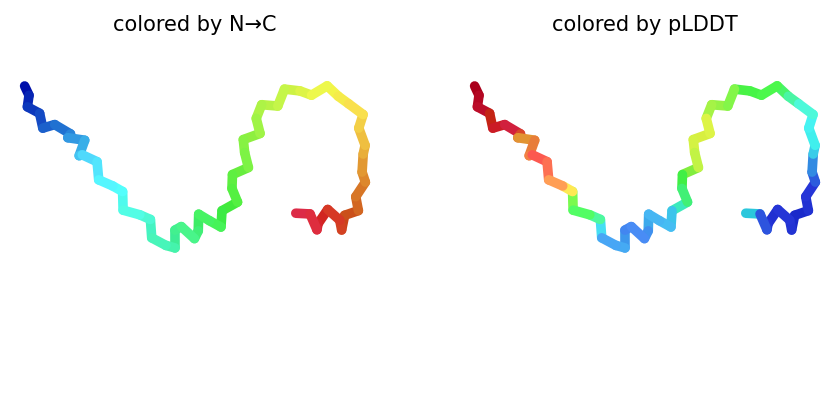

2024-11-12 14:00:34,093 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=70.9 pTM=0.238
2024-11-12 14:00:34,673 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=73.1 pTM=0.253 tol=2.8
2024-11-12 14:00:35,254 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=73.8 pTM=0.249 tol=2.65
2024-11-12 14:00:35,835 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=73.9 pTM=0.251 tol=2.6
2024-11-12 14:00:35,836 alphafold2_ptm_model_2_seed_000 took 2.3s (3 recycles)


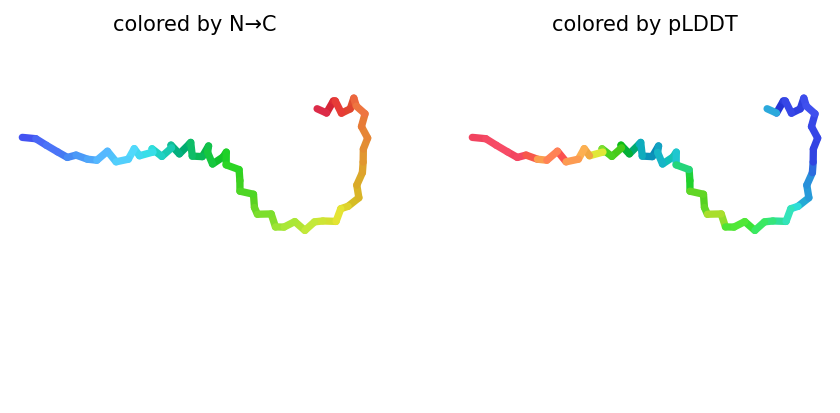

2024-11-12 14:00:51,513 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=70.9 pTM=0.229
2024-11-12 14:00:52,048 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=71.1 pTM=0.236 tol=4.52
2024-11-12 14:00:52,583 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=72.3 pTM=0.237 tol=4.18
2024-11-12 14:00:53,119 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=72.8 pTM=0.243 tol=3.23
2024-11-12 14:00:53,120 alphafold2_ptm_model_3_seed_000 took 17.2s (3 recycles)


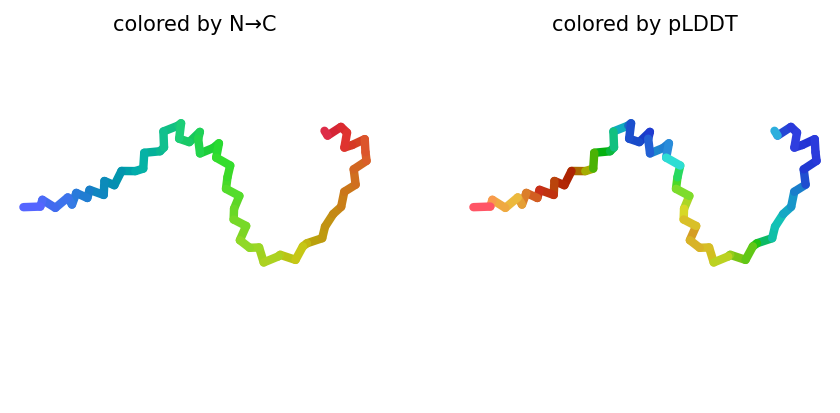

2024-11-12 14:00:53,853 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=72.4 pTM=0.219
2024-11-12 14:00:54,383 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=74.9 pTM=0.236 tol=3.44
2024-11-12 14:00:54,912 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=75.3 pTM=0.236 tol=1.96
2024-11-12 14:00:55,442 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=75.6 pTM=0.243 tol=0.675
2024-11-12 14:00:55,444 alphafold2_ptm_model_4_seed_000 took 2.1s (3 recycles)


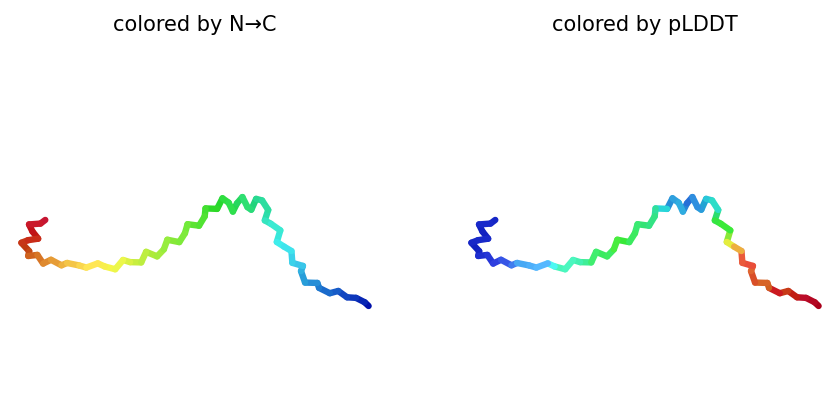

2024-11-12 14:00:56,098 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=68.1 pTM=0.227
2024-11-12 14:00:56,631 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=69.3 pTM=0.24 tol=5.73
2024-11-12 14:00:57,160 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=70.2 pTM=0.239 tol=1.69
2024-11-12 14:00:57,690 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=70.9 pTM=0.242 tol=2.45
2024-11-12 14:00:57,691 alphafold2_ptm_model_5_seed_000 took 2.1s (3 recycles)


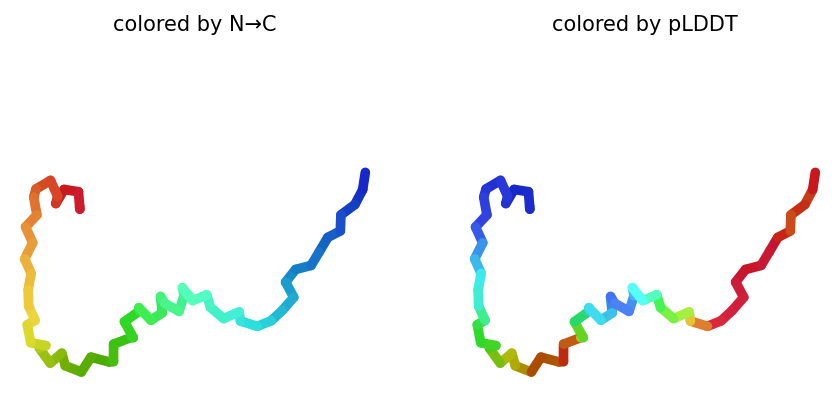

2024-11-12 14:00:57,830 reranking models by 'plddt' metric
2024-11-12 14:00:57,831 rank_001_alphafold2_ptm_model_4_seed_000 pLDDT=75.6 pTM=0.243
2024-11-12 14:00:57,831 rank_002_alphafold2_ptm_model_2_seed_000 pLDDT=73.9 pTM=0.251
2024-11-12 14:00:57,832 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=73.1 pTM=0.292
2024-11-12 14:00:57,833 rank_004_alphafold2_ptm_model_3_seed_000 pLDDT=72.8 pTM=0.243
2024-11-12 14:00:57,833 rank_005_alphafold2_ptm_model_5_seed_000 pLDDT=70.9 pTM=0.242
2024-11-12 14:00:59,205 Done


0

In [ ]:
# Configuration parameters for the model and visualization
use_amber = True            # Enable Amber for molecular dynamics if True
use_templates = True        # Enable template-based modeling if True
num_relax = 0               # Set to >0 to enable relaxation steps, otherwise 0
python_version = "3.8"      # Define the Python version
display_images = True       # Display MSA and protein structure images if True

# Import necessary libraries and modules for structure prediction
import os
import sys
import warnings
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from Bio import BiopythonDeprecationWarning
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2
from colabfold.colabfold import plot_protein

# Suppress certain warnings to avoid clutter in the output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)

# Check for Tesla K80 GPU (which has limitations for large sequences)
try:
    K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
    if "1" in K80_chk:
        print("WARNING: found GPU Tesla K80: limited to total length < 1000")
        os.environ.pop("TF_FORCE_UNIFIED_MEMORY", None)
        os.environ.pop("XLA_PYTHON_CLIENT_MEM_FRACTION", None)
except:
    K80_chk = "0"

# Add Amber's Python path if Amber is enabled
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

# Define image display callbacks for MSA and protein structure visualization
def input_features_callback(input_features):
    if display_images:
        plot_msa_v2(input_features)  # Plot MSA
        plt.show()
        plt.close()

def prediction_callback(protein_obj, length, prediction_result, input_features, mode):
    model_name, relaxed = mode
    if not relaxed and display_images:
        fig = plot_protein(protein_obj, Ls=length, dpi=150)  # Plot protein structure
        plt.show()
        plt.close()

# Setup result directory and logging
result_dir = jobname
log_filename = os.path.join(jobname, "log.txt")
setup_logging(Path(log_filename))  # Initialize logging for model output

# Set up query sequences and model type based on query complexity
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, "auto")
use_cluster_profile = not ("multimer" in model_type and max_msa is not None)

# Download model parameters based on selected model type
download_alphafold_params(model_type, Path("."))

# Run the model with specified parameters and callbacks
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=None,
    num_relax=num_relax,
    msa_mode="mmseqs2_uniref_env",
    model_type=model_type,
    num_models=5,
    num_recycles=3,
    relax_max_iterations=200,
    recycle_early_stop_tolerance=0.0,
    num_seeds=1,
    use_dropout=False,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode="unpaired_paired",
    pairing_strategy="greedy",
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=200,
    zip_results=False,
    save_all=False,
    max_msa=None,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=False,
    user_agent="colabfold/google-colab-main",
)

# Zip the results directory for easy download
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

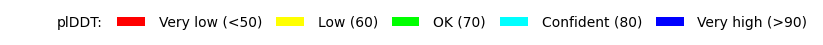

In [ ]:
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list

# Visualization configuration parameters
rank_num = 1                    # Rank of the model to display
color = "lDDT"                   # Color scheme for visualization (options: "lDDT", "rainbow", "chain")
show_sidechains = False          # Set True to show sidechains in structure
show_mainchains = False          # Set True to show mainchains in structure

# Retrieve the PDB file for the specified model rank
tag = results["rank"][0][rank_num - 1]  # Rank tag based on the model results
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)      # Search for PDB file using glob

# Check if the PDB file exists; if not, print an error message
if not pdb_file:
    print(f"Error: PDB file {pdb_filename} not found!")
else:
    # Define the function to visualize the PDB model
    def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
        model_name = f"rank_{rank_num}"
        view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')  # Initialize 3Dmol viewer

        # Load and display the PDB file
        with open(pdb_file[0], 'r') as pdb_data:
            view.addModel(pdb_data.read(), 'pdb')

        # Apply coloring style based on the chosen scheme
        if color == "lDDT":  # Color by pLDDT scores
            view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
        elif color == "rainbow":  # Use a rainbow spectrum
            view.setStyle({'cartoon': {'color': 'spectrum'}})
        elif color == "chain":  # Color each chain uniquely if structure is multimeric
            chains = len(queries[0][1]) + 1 if is_complex else 1
            for n, chain, color in zip(range(chains), alphabet_list, pymol_color_list):
                view.setStyle({'chain': chain}, {'cartoon': {'color': color}})

        # Display sidechains if enabled
        if show_sidechains:
            BB = ['C', 'O', 'N']  # Backbone atoms
            view.addStyle({'and': [{'resn': ["GLY", "PRO"], 'invert': True}, {'atom': BB, 'invert': True}]},
                          {'stick': {'colorscheme': "WhiteCarbon", 'radius': 0.3}})
            view.addStyle({'and': [{'resn': "GLY"}, {'atom': 'CA'}]},
                          {'sphere': {'colorscheme': "WhiteCarbon", 'radius': 0.3}})
            view.addStyle({'and': [{'resn': "PRO"}, {'atom': ['C', 'O'], 'invert': True}]},
                          {'stick': {'colorscheme': "WhiteCarbon", 'radius': 0.3}})

        # Display main chains if enabled
        if show_mainchains:
            BB = ['C', 'O', 'N', 'CA']
            view.addStyle({'atom': BB}, {'stick': {'colorscheme': "WhiteCarbon", 'radius': 0.3}})

        view.zoomTo()  # Center the view on the structure
        return view

    # Call the function to visualize the PDB structure
    show_pdb(rank_num, show_sidechains, show_mainchains, color).show()

    # Plot the pLDDT color legend if using the "lDDT" color scheme
    if color == "lDDT":
        plot_plddt_legend().show()


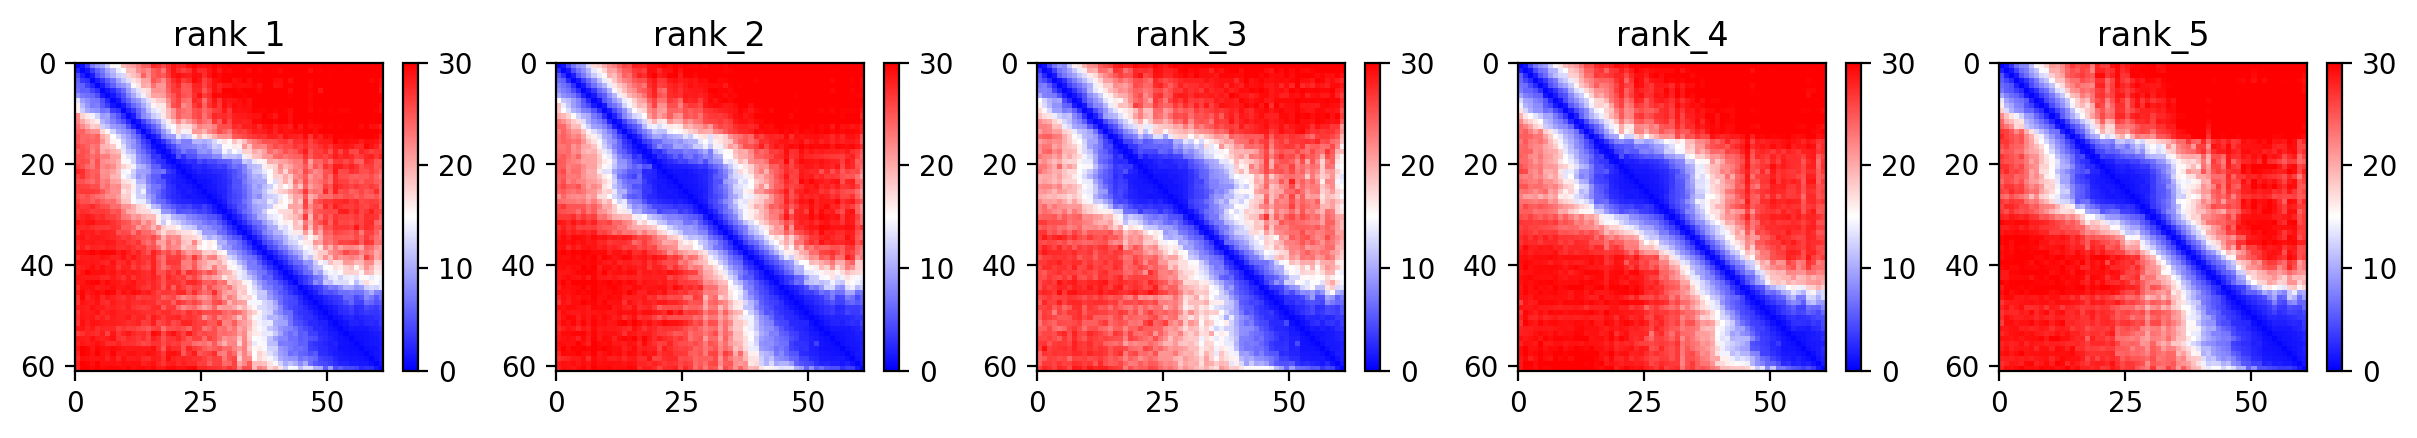
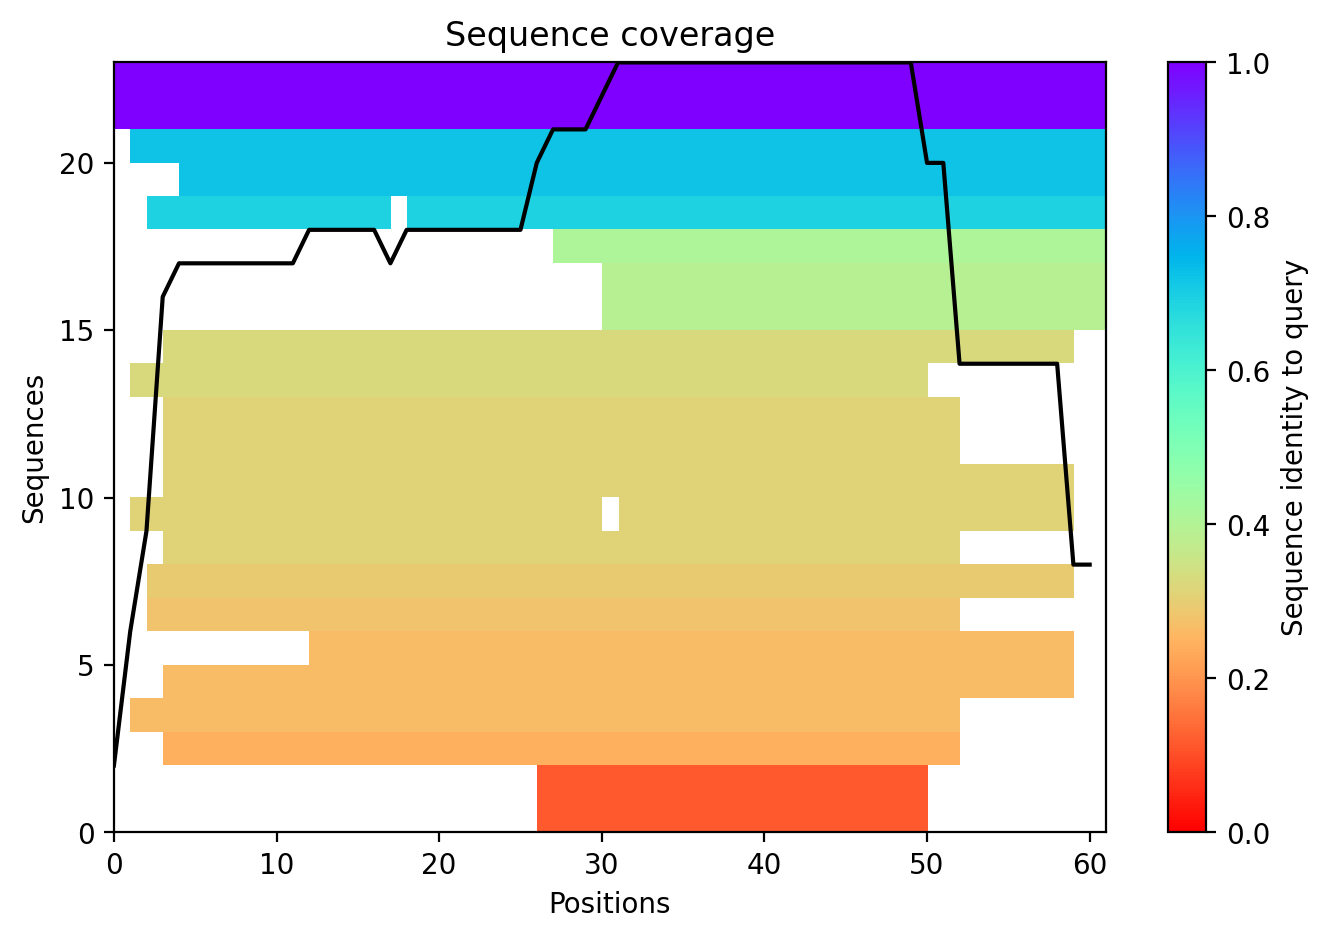
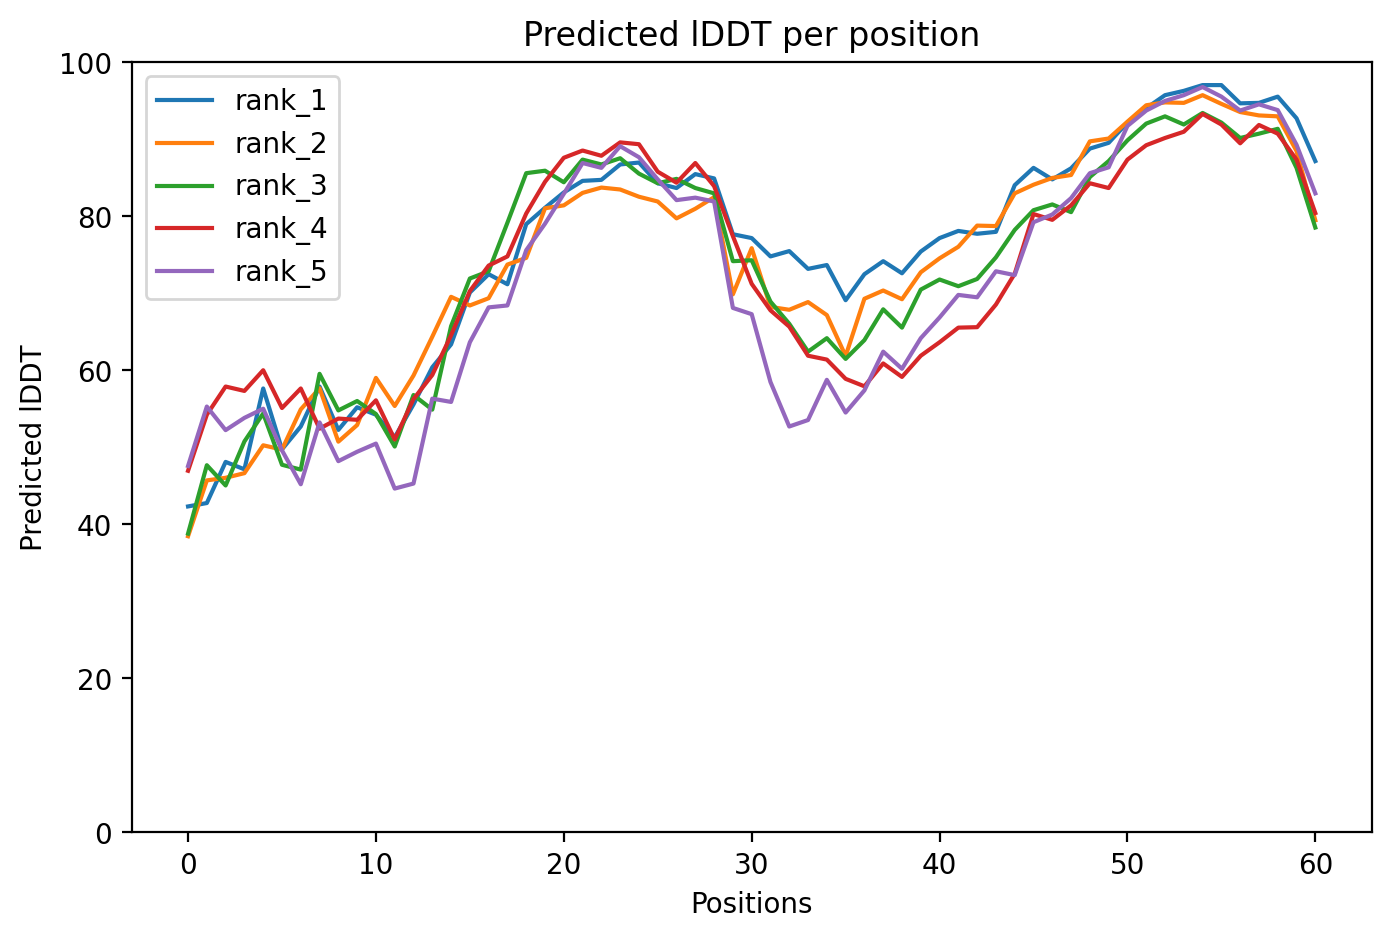

In [ ]:
from IPython.display import display, HTML
import base64
from html import escape
import os

# Function to convert an image file to a base64 data URL for HTML display
def image_to_data_url(filename):
    ext = filename.split('.')[-1]
    prefix = f'data:image/{ext};base64,'
    with open(filename, 'rb') as f:
        img = f.read()
    return prefix + base64.b64encode(img).decode('utf-8')

# Define paths for PAE, coverage, and pLDDT images
pae = ""  # Initialize PAE plot variable
pae_file = os.path.join(jobname, f"{jobname}{jobname_prefix}_pae.png")  # PAE file path
if os.path.isfile(pae_file):  # Check if PAE file exists
    pae = image_to_data_url(pae_file)  # Convert PAE image to data URL

# Convert coverage and pLDDT images to data URLs
cov = image_to_data_url(os.path.join(jobname, f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname, f"{jobname}{jobname_prefix}_plddt.png"))

# Display an HTML layout to showcase images
display(HTML(f"""
<style>
  img {{
    float: left;
  }}
  .full {{
    max-width: 100%;
  }}
  .half {{
    max-width: 50%;
  }}
  @media (max-width: 640px) {{
    .half {{
      max-width: 100%;
    }}
  }}
</style>
<div style="max-width: 90%; padding: 2em;">
  <h1>Plots for {escape(jobname)}</h1>
  {f'<img src="{pae}" class="full" />' if pae else ''}  <!-- Full-width PAE plot if available -->
  <img src="{cov}" class="half" />  <!-- Half-width coverage plot -->
  <img src="{plddt}" class="half" /> <!-- Half-width pLDDT plot -->
</div>
"""))

In [ ]:
# Download the results zip file locally
files.download(f"{jobname}.result.zip")

# If Google Drive upload is enabled, upload the results to Google Drive
if save_to_google_drive == True and drive:
    # Create a new file on Google Drive with the specified jobname
    uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})

    # Set the content of the file to the result zip and upload
    uploaded.SetContentFile(f"{jobname}.result.zip")
    uploaded.Upload()

    # Print the Google Drive file ID after upload
    print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validating structure for ProteinStructPrediction_5993e/ProteinStructPrediction_5993e_unrelaxed_rank_001_alphafold2_ptm_model_4_seed_000.pdb


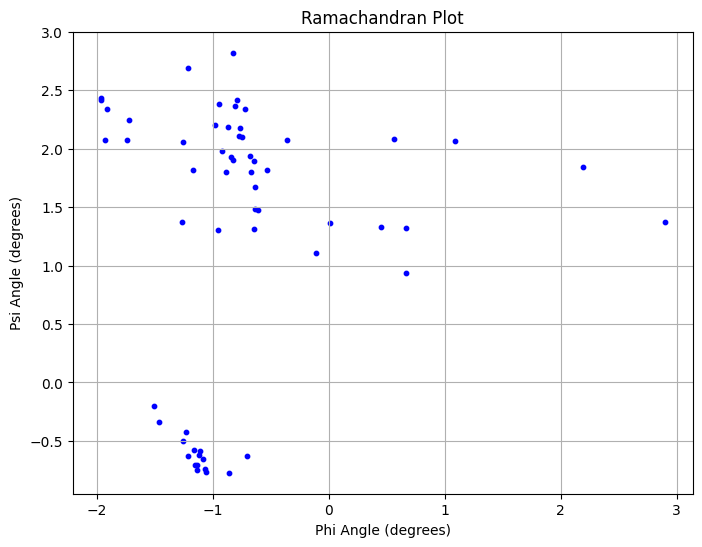

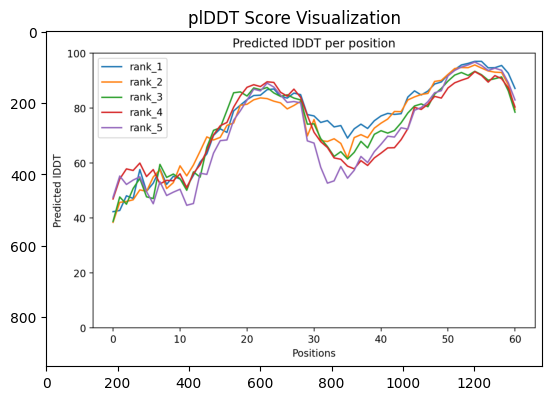

Clash Score (Number of clashes): 756 out of 2832 atom pairs checked


In [ ]:
import os
import matplotlib.pyplot as plt
from Bio import PDB
import numpy as np

# Function to generate Ramachandran plot from the PDB file
def generate_ramachandran_plot(pdb_filename):
    # Parse the PDB file
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("Protein", pdb_filename)

    ramachandran_angles = []

    # Iterate through models and chains to extract phi, psi angles
    for model in structure:
        for chain in model:
            ppb = PDB.PPBuilder()
            for pp in ppb.build_peptides(chain):
                phi_psi = pp.get_phi_psi_list()
                for angles in phi_psi:
                    if None not in angles:
                        ramachandran_angles.append(angles)

    # Extract phi and psi angles for plotting
    phi_angles = [x[0] for x in ramachandran_angles]
    psi_angles = [x[1] for x in ramachandran_angles]

    # Plot Ramachandran plot
    plt.figure(figsize=(8, 6))
    plt.scatter(phi_angles, psi_angles, s=10, color='blue')
    plt.title('Ramachandran Plot')
    plt.xlabel('Phi Angle (degrees)')
    plt.ylabel('Psi Angle (degrees)')
    plt.grid(True)
    plt.show()

# Function to visualize plDDT score image
def evaluate_plddt_scores(pdb_filename):
    # Check if the plDDT score image exists and display it
    plddt_image_path = os.path.join(jobname, f"{jobname}{jobname_prefix}_plddt.png")
    if os.path.exists(plddt_image_path):
        plt.imshow(plt.imread(plddt_image_path))
        plt.title('plDDT Score Visualization')
        plt.show()
    else:
        print("plDDT score image not found. Please ensure the plDDT scores are generated.")

# Function to calculate clash score based on atom distance
def calculate_clash_score(pdb_filename, distance_threshold=2.0):
    # Parse the PDB structure and calculate clashes
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("Protein", pdb_filename)

    clash_score = 0
    atom_pairs_checked = 0

    # Check atom pairs for clashes (distance < threshold)
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom1 in residue:
                    if atom1.get_id() == "H":  # Skip hydrogens
                        continue
                    for atom2 in residue:
                        if atom1 != atom2:
                            distance = atom1 - atom2
                            if distance < distance_threshold:
                                clash_score += 1
                            atom_pairs_checked += 1

    # Return the clash score
    return clash_score, atom_pairs_checked

# File paths and job details
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
print(f"Validating structure for {pdb_filename}")

# Step 1: Generate and display Ramachandran plot
generate_ramachandran_plot(pdb_filename)

# Step 2: Display plDDT score image (confidence in structure prediction)
evaluate_plddt_scores(pdb_filename)

# Step 3: Calculate and print clash score (protein geometry check)
clash_score, atom_pairs_checked = calculate_clash_score(pdb_filename)
print(f"Clash Score (Number of clashes): {clash_score} out of {atom_pairs_checked} atom pairs checked")